# creating our enhanced model
### enhancements
- we need to model availability into our model 
- we need to model repeat consumption as users will repeatedly consume the days after but two days after less and 3 days after it is not as likely
- we need to model users with high interactions and users with low interactions. Tow models?

create a NCF
test it
create an availability measure. This could be doing a daily version where users are modelled by their day to day interactions? 
test model on upper and lower quartiles, see if there is a change in acc



In [1]:
import os
import pandas as pd
import numpy as np
file_path = os.path.join(os.getcwd(),'Datasets/100k_a.csv')
cols = ["user","stream","streamer","start","stop"]
data = pd.read_csv(file_path, header=None, names=cols)
data.user = pd.factorize(data.user)[0]+1
data['streamer_raw'] = data.streamer
data.streamer = pd.factorize(data.streamer)[0]+1
print("Num users: ", data.user.nunique())
print("Num streamers: ", data.streamer.nunique())
print("Num interactions: ", len(data))
data['day'] = data.start // (24 * 6)
data.streamer = pd.factorize(data.streamer)[0]+1
data.user = pd.factorize(data.user)[0]+1
data.stream = pd.factorize(data.stream)[0]+1

#let's train on the top 100,000 entries. These are the entries which decrease the sparsity the most.
from sklearn.preprocessing import MinMaxScaler
#calculate the user incteraction frequency
user_interactions = data.groupby('user').size()
streamer_interactions = data.groupby('streamer').size()
#rank the users and streamers by their frequency
user_ranks = user_interactions.rank(method='first', ascending=False)
streamer_ranks = streamer_interactions.rank(method='first', ascending=False)
#score the interactions and select the top 100,000
data['user_score'] = data['user'].map(user_ranks)
data['streamer_score'] = data['streamer'].map(streamer_ranks)
data['combined_score'] = data['user_score'] + data['streamer_score']
data['rating'] = data.stop - data.start


top_data = data.nsmallest(100000, 'combined_score')
data = top_data.drop(columns=['user_score', 'streamer_score', 'combined_score'])

data = data.groupby('user').filter(lambda x: len(x) > 3)


data['day'] = data.start // (24 * 6)
data.streamer = pd.factorize(data.streamer)[0]+1
data.user = pd.factorize(data.user)[0]+1
data.stream = pd.factorize(data.stream)[0]+1
data.user = pd.factorize(data.user)[0]+1

print("Num users: ", data.user.nunique())
print("Num streamers: ", data.streamer.nunique())
print("Num interactions: ", len(data))

# check for sparsity of the data
potential_num_interactions = data.streamer.nunique() * data.user.nunique()
num_interactions = len(data['streamer']) #each row in the filtered_data is an interaction
sparsity = (1-num_interactions /potential_num_interactions) * 100
print(f'sparsity is {sparsity: .2f}%')



Num users:  100000
Num streamers:  162625
Num interactions:  3051733
Num users:  1431
Num streamers:  1380
Num interactions:  99924
sparsity is  94.94%


In [2]:
from torch.utils.data import Dataset
import torch
class InteractionDataset(Dataset):
    def __init__(self, df, split_type='train'):
        # Sort by user and start time
        sorted_df = df.sort_values(by=['user', 'start'])
        
        # Splitting the data
        if split_type == 'train':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[:-2]).reset_index(drop=True)
        elif split_type == 'eval':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[-2]).reset_index(drop=True)
            if len(self.data.user) != data.user.nunique():
                print('error in test creation ')
        elif split_type == 'test':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
            if len(self.data.user) != data.user.nunique():
                print('error in test creation ')

        self.users = self.data['user'].values
        self.items = self.data['stream'].values
        self.ratings = self.data['rating'].values
        self.min_rating = self.ratings.min()
        self.max_rating = self.ratings.max()

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        normalized_rating = (self.ratings[idx] - self.min_rating) / (self.max_rating - self.min_rating)
        if normalized_rating > 1:
            print('rating is fgreater then 1')
        return self.users[idx], self.items[idx], normalized_rating

    
from torch.utils.data import DataLoader
batch_size = 124
train_dataset = InteractionDataset(data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = InteractionDataset(data, 'test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
eval_dataset = InteractionDataset(data, 'eval')
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the device - It will print 'cuda' if GPU is available or 'cpu' otherwise
print(f"Using device: {device}")

Using device: cuda:0


Epoch 0, train Loss: 0.2190, val loss: 0.1843
Epoch 1, train Loss: 0.1737, val loss: 0.1327
Epoch 2, train Loss: 0.1090, val loss: 0.0731
Epoch 3, train Loss: 0.0542, val loss: 0.0368
Epoch 4, train Loss: 0.0250, val loss: 0.0203
Epoch 5, train Loss: 0.0120, val loss: 0.0143
Epoch 6, train Loss: 0.0066, val loss: 0.0122
Epoch 7, train Loss: 0.0043, val loss: 0.0114


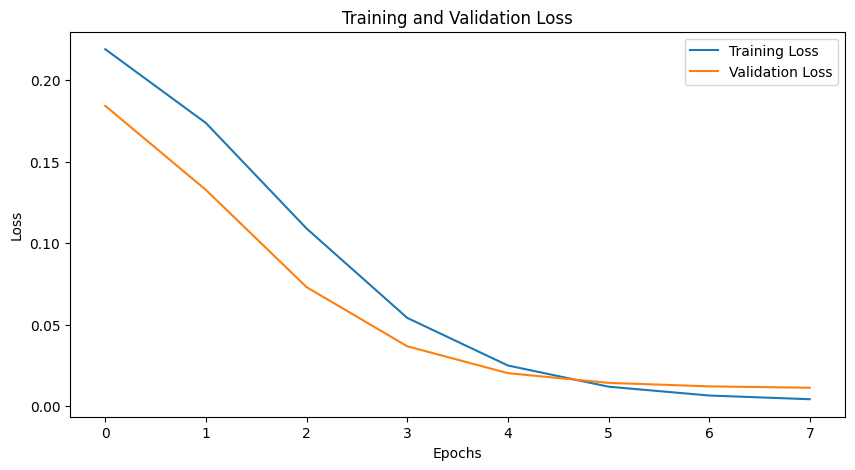

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#items in this will be streams 
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size, layers):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users+1, embedding_size)
        self.item_embedding = nn.Embedding(num_items+1, embedding_size)
        self.fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i + 1]))

        self.relu = nn.ReLU()
        self.criterion = nn.MSELoss()

    def forward(self, user_id, item_id):
        user_vec = self.user_embedding(user_id)
        item_vec = self.item_embedding(item_id)
        vector = torch.cat([user_vec, item_vec], dim=-1)
        for layer in self.fc_layers[:-1]:
            vector = self.relu(layer(vector))
        prediction = torch.sigmoid(self.fc_layers[-1](vector))
        return prediction
   

embedding_size = 64
layers = [2 * embedding_size,64, 32, 16, 1]
num_epochs = 8
train_arr = np.zeros(num_epochs)
test_arr = np.zeros(num_epochs)
model = NCF(data.user.nunique(), data.stream.nunique(), embedding_size, layers).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids, item_ids, ratings = user_ids.to(device), item_ids.to(device), ratings.to(device)
        optimiser.zero_grad()
        predictions = model(user_ids, item_ids)
        loss = model.criterion(predictions.view(-1), ratings.float())
        loss.backward()
        optimiser.step()
        total_train_loss += loss.item()
 
    avg_train_loss =  total_train_loss / len(train_loader)
    
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0
        
        for user_ids, item_ids, ratings in eval_loader:
            
            user_ids, item_ids, ratings = user_ids.to(device), item_ids.to(device), ratings.to(device)
            predictions = model(user_ids, item_ids)
            loss = model.criterion(predictions.view(-1), ratings.float())
            total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
    train_arr[epoch], test_arr[epoch] = avg_train_loss, avg_val_loss
    print(f"Epoch {epoch}, train Loss: {avg_train_loss:.4f}, val loss: {avg_val_loss:.4f}")
    torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_arr, label='Training Loss')
plt.plot(test_arr, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### creating a model that can factor in the day an interaction has occured.
this can help use identify availability as the model will be able to account for what day a stream was consumed. This will let the model learn that streams are not available as it does not see streams after a certain day. Another method could be to use an availability list that will zero items not in the available streams.

Epoch 0, train Loss: 0.0220, val loss: 0.0266
Epoch 1, train Loss: 0.0215, val loss: 0.0254
Epoch 2, train Loss: 0.0206, val loss: 0.0243
Epoch 3, train Loss: 0.0195, val loss: 0.0229
Epoch 4, train Loss: 0.0182, val loss: 0.0207
Epoch 5, train Loss: 0.0159, val loss: 0.0171
Epoch 6, train Loss: 0.0127, val loss: 0.0127
Epoch 7, train Loss: 0.0092, val loss: 0.0086
Epoch 8, train Loss: 0.0061, val loss: 0.0058
Epoch 9, train Loss: 0.0038, val loss: 0.0039
Epoch 10, train Loss: 0.0023, val loss: 0.0030
Epoch 11, train Loss: 0.0015, val loss: 0.0024
Epoch 12, train Loss: 0.0010, val loss: 0.0020
Epoch 13, train Loss: 0.0008, val loss: 0.0020
Epoch 14, train Loss: 0.0006, val loss: 0.0021
Epoch 15, train Loss: 0.0005, val loss: 0.0018
Epoch 16, train Loss: 0.0004, val loss: 0.0020


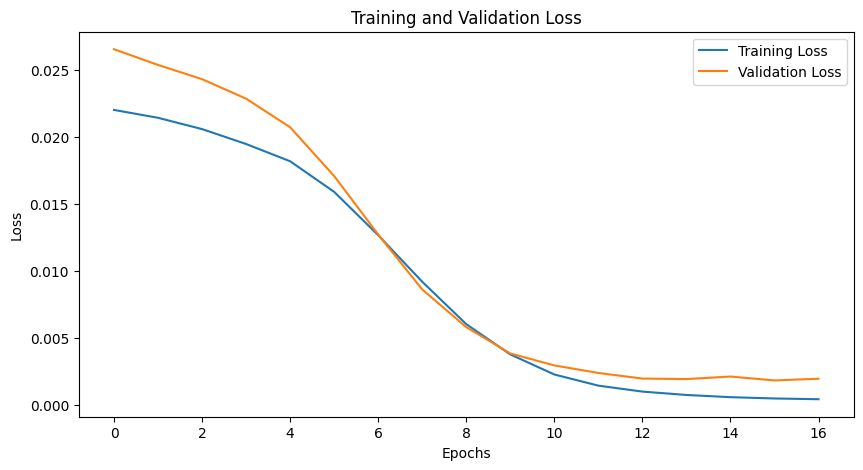

In [5]:

class DayInteractionDataset(Dataset):
    def __init__(self, df, split_type='train'):
        # Sort by user and start time
        sorted_df = df.sort_values(by=['user', 'start'])
        
        # Splitting the data
        if split_type == 'train':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[:-2]).reset_index(drop=True)
        elif split_type == 'eval':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[-2]).reset_index(drop=True)
            if len(self.data.user) != data.user.nunique():
                print('error in test creation ')
        elif split_type == 'test':
            self.data = sorted_df.groupby('user').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
            if len(self.data.user) != data.user.nunique():
                print('error in test creation ')

        self.users = self.data['user'].values
        self.items = self.data['stream'].values
        self.ratings = self.data['rating'].values
        self.day = self.data['day'].values
        self.min_rating = self.ratings.min()
        self.max_rating = self.ratings.max()

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        normalized_rating = (self.ratings[idx] - self.min_rating) / (self.max_rating - self.min_rating)
        if normalized_rating > 1:
            print('ERROR: rating is greater then 1')
        return self.users[idx], self.items[idx], self.day[idx], normalized_rating

    
from torch.utils.data import DataLoader
batch_size = 1000
day_train_dataset = DayInteractionDataset(data)
day_train_loader = DataLoader(day_train_dataset, batch_size=batch_size, shuffle=True)
day_test_dataset = DayInteractionDataset(data, 'test')
day_test_loader = DataLoader(day_test_dataset, batch_size=batch_size, shuffle=True)
day_eval_dataset = DayInteractionDataset(data, 'eval')
day_eval_loader = DataLoader(day_eval_dataset, batch_size=batch_size, shuffle=True)



import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#items in this will be streams 
class DNCF(nn.Module):
    def __init__(self, num_users, num_items,num_days, embedding_size, layers):
        super(DNCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users+1, embedding_size)
        self.item_embedding = nn.Embedding(num_items+1, embedding_size)
        self.day_embedding = nn.Embedding(num_days+1, embedding_size)
        self.fc_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i + 1]))

        self.relu = nn.ReLU()
        self.criterion = nn.MSELoss()

    def forward(self, user_id, item_id, day):
        user_vec = self.user_embedding(user_id)
        item_vec = self.item_embedding(item_id)
        day_vec = self.day_embedding(day)
        vector = torch.cat([user_vec, item_vec, day_vec], dim=-1)
        for layer in self.fc_layers[:-1]:
            vector = self.relu(layer(vector))
        prediction = torch.sigmoid(self.fc_layers[-1](vector))
        return prediction
   

day_embedding_size = 64
day_layers = [3 * embedding_size, 4*64, 2*64, 64, 32, 16, 1]
day_num_epochs = 17
train_arr = np.zeros(day_num_epochs)
test_arr = np.zeros(day_num_epochs)
model = DNCF(data.user.nunique(), data.stream.nunique(), data.day.nunique(), day_embedding_size, day_layers).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)
for epoch in range(day_num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for user_ids, item_ids, day_ids, ratings in day_train_loader:
        user_ids, item_ids, day_ids, ratings = user_ids.to(device), item_ids.to(device), day_ids.to(device), ratings.to(device)
        optimiser.zero_grad()
        predictions = model(user_ids, item_ids, day_ids)
        loss = model.criterion(predictions.view(-1), ratings.float())
        loss.backward()
        optimiser.step()
        total_train_loss += loss.item()
 
    avg_train_loss =  total_train_loss / len(train_loader)
    
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0
        
        for user_ids, item_ids, day_ids, ratings in day_eval_loader:
            
            user_ids, item_ids, day_ids, ratings = user_ids.to(device), item_ids.to(device), day_ids.to(device), ratings.to(device)
            predictions = model(user_ids, item_ids, day_ids)
            loss = model.criterion(predictions.view(-1), ratings.float())
            total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
    train_arr[epoch], test_arr[epoch] = avg_train_loss, avg_val_loss
    print(f"Epoch {epoch}, train Loss: {avg_train_loss:.4f}, val loss: {avg_val_loss:.4f}")
    torch.save(model.state_dict(), f'day_model_epoch_{epoch}.pth')
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_arr, label='Training Loss')
plt.plot(test_arr, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
#load the best day_model 


day_model = DNCF(data.user.nunique(), data.stream.nunique(), data.day.nunique(), day_embedding_size, day_layers)
day_model.load_state_dict(torch.load(f'day_model_epoch_{day_num_epochs-1}.pth'))
day_model.eval()




train_arr = np.zeros(num_epochs)
test_arr = np.zeros(num_epochs)
model = NCF(data.user.nunique(), data.stream.nunique(), embedding_size, layers)
model.load_state_dict(torch.load(f'model_epoch_{num_epochs-1}.pth'))
model.eval()


NCF(
  (user_embedding): Embedding(1432, 64)
  (item_embedding): Embedding(28294, 64)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (relu): ReLU()
  (criterion): MSELoss()
)

### model analysis
we will use scores such as Hit rate, coverage and Top-N to measure the accuracy of the models predictions. 

- create a function to generate N items
- get the hit rate of the models

- NDCG score

In [ ]:
def predict_top_n(model, user_id, n=10):
    # Predict scores for all items for this user
    predictions = [model(user_id, item_id) for item_id in data.stream.unique()]

    # Pair each item with its score
    scored_items = list(zip(data.stream.unique(), predictions))

    # Sort by score in descending order
    scored_items.sort(key=lambda x: x[1], reverse=True)

    # Take the top N items
    top_n_items = [item for item, _ in scored_items[:n]]

    return top_n_items
def predict_day_top_n(model, user_id, day, n=10):
    # Predict scores for all items for this user
    n_streams = data.stream.nunique()
    user_tensor = torch.tensor([user_id]* n_streams)
    stream_tensor = torch.tensor(data.stream.unique())
    day_tensor = torch.tensor([day]*n_streams)
    predictions = model(user_tensor, stream_tensor, day_tensor)

    # Pair each item with its score
    scored_items = list(zip(data.stream.unique(), predictions))

    # Sort by score in descending order
    scored_items.sort(key=lambda x: x[1], reverse=True)

    # Take the top N items
    top_n_items = [item for item, _ in scored_items[:n]]

    return top_n_items
    
def calc_HIT_at_n(test_loader, model, top_n):
    hits = 0
    total_users = 0

    for user_ids, item_ids, days, _ in test_loader:
        for user_id, true_item_id, day_id in zip(user_ids, item_ids, days):
            predicted_items = predict_day_top_n(model, user_id.item(), day_id.item(), top_n)
            
            if true_item_id.item() in predicted_items:
                hits += 1
        total_users += user_ids.size(0)

    hit_rate = hits / total_users
    return hit_rate
print(calc_HIT_at_n(day_test_loader, day_model, 1))
